<a href="https://colab.research.google.com/github/Robby-Akbar/ProjectNLP/blob/main/colab/data_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Download Movie Dataset from Kaggle

In [ ]:
! pip install -q kaggle #install kaggle

In [ ]:
from google.colab import files
files.upload() #untuk upload file ke colab

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"robbyakbar","key":"f51ace809ca2b3895ec0d9893bd7386c"}'}

In [ ]:
! cp kaggle.json ~/.kaggle/ #pindahkan file api kaggle ke folder root kaggle

In [ ]:
#ubah permission file kaggle hanya bisa diakses user untuk (read - write)
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#download dataset from https://www.kaggle.com/rounakbanik/the-movies-dataset
!kaggle datasets download -d rounakbanik/the-movies-dataset

 99% 225M/228M [00:01<00:00, 136MB/s]
100% 228M/228M [00:01<00:00, 128MB/s]


In [ ]:
#ekstrak file dataset
!unzip /content/the-movies-dataset.zip

Archive:  /content/the-movies-dataset.zip
  inflating: credits.csv             
  inflating: keywords.csv            
  inflating: links.csv               
  inflating: links_small.csv         
  inflating: movies_metadata.csv     
  inflating: ratings.csv             
  inflating: ratings_small.csv       


#Cleaning movies_metadata

In [ ]:
import pandas as pd
import ast
import seaborn as sns

from nltk.corpus import stopwords
#nltk library for removing Stop words
import nltk
#nltk.download()
nltk.download("stopwords")

from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##Filter Data

In [ ]:
#membaca file csv dataset dan menampilkan yang teratas
data = pd.read_csv("/content/movies_metadata.csv")
data.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [ ]:
#memfilter column yang hanya dibutuhkan
filtered_data = data.filter(['genres','id', 'original_title', 'overview', 'tagline'], axis=1)
len(filtered_data)

45466

In [ ]:
genres = filtered_data['genres'].tolist()

In [ ]:
genre_per_movie = [] #membuat array untuk seluruh genre pada setiap movie
genre_dict = {} #membuat json object untuk hasil hitung genre

#melakukan looping untuk menghitung dan format data genres
for genre in genres:
  genre = ast.literal_eval(genre)
  genre_list = [] #membuat list genre pada suatu movie
  for val in genre:
    genre_list.append(val['name'])
    if val['name'] in genre_dict:
      genre_dict[val['name']] += 1
    else:
      genre_dict[val['name']] = 1
  genre_per_movie.append(genre_list)

#mendefinisikan key & value genre_dic
genre_dict = {key:val for key, val in genre_dict.items() if val != 1}
genre_dict #menampilkan

{'Action': 6596,
 'Adventure': 3496,
 'Animation': 1935,
 'Comedy': 13182,
 'Crime': 4307,
 'Documentary': 3932,
 'Drama': 20265,
 'Family': 2770,
 'Fantasy': 2313,
 'Foreign': 1622,
 'History': 1398,
 'Horror': 4673,
 'Music': 1598,
 'Mystery': 2467,
 'Romance': 6735,
 'Science Fiction': 3049,
 'TV Movie': 767,
 'Thriller': 7624,
 'War': 1323,
 'Western': 1042}

In [ ]:
#mengubah kolom genres menjadi genre yang sudah diformat
filtered_data['genres'] = genre_per_movie
filtered_data.head()

,genres,id,original_title,overview,tagline
0,"[Animation, Comedy, Family]",862,Toy Story,"Led by Woody, Andy's toys live happily in his ...",NaN
1,"[Adventure, Fantasy, Family]",8844,Jumanji,When siblings Judy and Peter discover an encha...,Roll the dice and unleash the excitement!
2,"[Romance, Comedy]",15602,Grumpier Old Men,A family wedding reignites the ancient feud be...,Still Yelling. Still Fighting. Still Ready for...
3,"[Comedy, Drama, Romance]",31357,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",Friends are the people who let you be yourself...
4,[Comedy],11862,Father of the Bride Part II,Just when George Banks has recovered from his ...,Just When His World Is Back To Normal... He's ...


In [ ]:
#memfilter data movie yang tidak terdapat genre
filtered_data = filtered_data[filtered_data['genres'].map(lambda d: len(d)) > 0]
len(filtered_data)

43024

genres                0
id                    0
original_title        0
overview            697
tagline           22878
dtype: int64


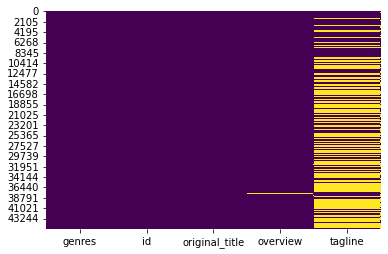

In [ ]:
#menghitung dan menampilkan kolom yang NaN
print(filtered_data.isnull().sum())
sns.heatmap(filtered_data.isnull(),cbar=False, cmap='viridis')

In [ ]:
#drop data NaN
filtered_data.dropna(inplace=True)
filtered_data.isnull().sum()

genres            0
id                0
original_title    0
overview          0
tagline           0
dtype: int64

In [ ]:
filtered_data = filtered_data.reset_index(drop=True)
filtered_data.shape

(20139, 5)

##Data Wrangling
Mendefiniskan kata yang biasa ditulis singkat

In [ ]:
# Reference for  list of contractions in English took from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

##Membuat fungsi clean_text

In [ ]:
#Cleaning the data
def clean_text(text, remove_stopwords = True):
    # Convert words to lower case
    text = text.lower()
    
    # using contractions to replace short with their longer forms 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    #removing stop words(optional if not nltk library)
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    return text

##Clean Text

In [ ]:
# Clean the Overview
clean_overview = []
for overview in filtered_data.overview:
    clean_overview.append(clean_text(overview))
print("Cleaning overview are complete.")

# Clean the Tagline
clean_tagline = []
for tagline in filtered_data.tagline:
    clean_tagline.append(clean_text(tagline, remove_stopwords=False))
print("Cleaning tagline are complete.")

Cleaning overview are complete.
Cleaning tagline are complete.


In [ ]:
filtered_data['overview'] = clean_overview
filtered_data['tagline'] = clean_tagline

In [ ]:
filtered_data.head()

,genres,id,original_title,overview,tagline
0,"[Adventure, Fantasy, Family]",8844,Jumanji,siblings judy peter discover enchanted board g...,roll the dice and unleash the excitement!
1,"[Romance, Comedy]",15602,Grumpier Old Men,family wedding reignites ancient feud next-doo...,still yelling. still fighting. still ready for...
2,"[Comedy, Drama, Romance]",31357,Waiting to Exhale,"cheated on, mistreated stepped on, women holdi...",friends are the people who let you be yourself...
3,[Comedy],11862,Father of the Bride Part II,"george banks recovered daughter's wedding, rec...",just when his world is back to normal... he is...
4,"[Action, Crime, Drama, Thriller]",949,Heat,"obsessive master thief, neil mccauley leads to...",a los angeles crime saga


##Save New Dataset

In [ ]:
train, test = train_test_split(filtered_data, test_size=0.2)
train, val = train_test_split(train, test_size=0.1)
print(type(train), type(test), type(val))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


In [ ]:
! mkdir /content/output
! mkdir /content/output/data

In [ ]:
val.to_csv("/content/output/data/val_data.csv", index=False)
test.to_csv("/content/output/data/test_data.csv", index=False)
train.to_csv("/content/output/data/train_data.csv", index=False)

In [ ]:
filtered_data.to_csv("/content/output/data/dataset_mod.csv", index=False)